In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d quadeer15sh/augmented-forest-segmentation

Dataset URL: https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation
License(s): other
 99% 170M/172M [00:08<00:00, 23.4MB/s]
100% 172M/172M [00:08<00:00, 20.3MB/s]


In [ ]:
!pip install torchsummary segmentation-models-pytorch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 35.9 MB/s eta 0:00:00


In [ ]:
!unzip -qq /content/augmented-forest-segmentation.zip

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu

In [ ]:
!pip install torchutils -q

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import pandas as pd
import segmentation_models_pytorch as smp

In [ ]:
import albumentations as A

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import cv2
from PIL import Image

In [ ]:
metadata_file = "/content/Forest Segmented/Forest Segmented/meta_data.csv"
metadata = pd.read_csv(metadata_file)
metadata.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [ ]:
train_val_paths, test_paths = train_test_split(metadata, test_size=0.2)
train_paths, val_paths = train_test_split(train_val_paths, test_size=0.15)

In [ ]:
val_paths.reset_index(drop=True).iloc[3]

,3
image,560353_sat_73.jpg
mask,560353_mask_73.jpg


In [ ]:
"/content/Forest Segmented/Forest Segmented/" + val_paths.reset_index(drop=True).iloc[3]['image']

'/content/Forest Segmented/Forest Segmented/560353_sat_73.jpg'

In [ ]:
train_paths.shape[0], val_paths.shape[0], test_paths.shape[0]

(3473, 613, 1022)

In [ ]:
class ForestAerialImages(Dataset):
    directory = "/content/Forest Segmented/Forest Segmented/"

    def __init__(self, paths, image_transform=None, paired_transform=None):
        self.paths = paths.reset_index(drop=True)
        self.image_transform = image_transform
        self.paired_transform = paired_transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        row = self.paths.iloc[idx]

        img = cv2.imread(self.directory + "images/" + row["image"])[..., ::-1]

        mask = cv2.imread(self.directory + "masks/" + row["mask"], cv2.IMREAD_GRAYSCALE)


        if self.paired_transform:
            aug = self.paired_transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.image_transform:
            img = self.image_transform(img.copy())

        #mask = cv2.resize(mask, (68, 68), interpolation=cv2.INTER_NEAREST)
        mask = torch.from_numpy(mask > 0).float().unsqueeze(0)

        return img, mask

In [ ]:
paired_transform = A.Compose([
    A.Rotate(limit=45),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomToneCurve(),
    A.RandomBrightnessContrast()
], is_check_shapes=False)

image_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_ds = ForestAerialImages(train_paths, image_transform, paired_transform)
val_ds = ForestAerialImages(val_paths, image_transform)
test_ds = ForestAerialImages(test_paths, image_transform)

In [ ]:
train_ds[0]

(tensor([[[-0.4980, -0.3804, -0.2941,  ..., -0.7176, -0.7176, -0.7255],
          [-0.4667, -0.4667, -0.2706,  ..., -0.7255, -0.7647, -0.7490],
          [-0.3882, -0.3333, -0.4275,  ..., -0.7490, -0.6863, -0.6941],
          ...,
          [-0.6157, -0.6000, -0.6157,  ..., -0.1059, -0.1686, -0.1843],
          [-0.5451, -0.5451, -0.5216,  ..., -0.1686, -0.2235, -0.1765],
          [-0.4745, -0.5373, -0.5451,  ..., -0.1765, -0.1529, -0.1843]],
 
         [[-0.5529, -0.4353, -0.3490,  ..., -0.7569, -0.7569, -0.7647],
          [-0.5216, -0.5216, -0.3255,  ..., -0.7647, -0.8039, -0.7804],
          [-0.4588, -0.4039, -0.4902,  ..., -0.7804, -0.7333, -0.7490],
          ...,
          [-0.7961, -0.7647, -0.8039,  ..., -0.3569, -0.4353, -0.4431],
          [-0.7098, -0.7176, -0.6706,  ..., -0.4353, -0.4902, -0.4353],
          [-0.6314, -0.7020, -0.7020,  ..., -0.4353, -0.4196, -0.4431]],
 
         [[-0.6314, -0.5137, -0.4275,  ..., -0.9059, -0.9059, -0.9216],
          [-0.6000, -0.6000,

In [ ]:
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_EVAL = 32

In [ ]:
train_dl = DataLoader(
    train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
    num_workers=2, pin_memory=True
)

val_dl = DataLoader(
    val_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
model = smp.Unet(encoder_name="mobilenet_v2", encoder_weights="imagenet", classes=1, activation="sigmoid", encoder_depth=5, decoder_channels=[1024, 512, 128, 64, 16]).to(device)

In [ ]:
tu.get_model_summary(model.to(device), torch.randn(16, 3, 256, 256, device=device))

Layer                                                      Kernel               Output            Params              FLOPs
0_encoder.features.0.Conv2d_0                             [3, 32, 3, 3]    [16, 32, 128, 128]          864      226,492,416
1_encoder.features.0.BatchNorm2d_1                                 [32]    [16, 32, 128, 128]           64       33,554,432
2_encoder.features.0.ReLU6_2                                          -    [16, 32, 128, 128]            0                0
3_encoder.features.1.conv.0.Conv2d_0                      [1, 32, 3, 3]    [16, 32, 128, 128]          288       75,497,472
4_encoder.features.1.conv.0.BatchNorm2d_1                          [32]    [16, 32, 128, 128]           64       33,554,432
5_encoder.features.1.conv.0.ReLU6_2                                   -    [16, 32, 128, 128]            0                0
6_encoder.features.1.conv.Conv2d_1                       [32, 16, 1, 1]    [16, 16, 128, 128]          512      134,217,728
7_encode

In [ ]:
def get_metrics(output, mask):
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask.int(), mode='binary', threshold=0.5)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").cpu()
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro").cpu()
    return iou_score, accuracy

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    # fonte: https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html#AverageMeter
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_step(model, train_dl, loss_fn, optimizer, device):
    model.train()

    train_loss = AverageMeter()
    train_acc = AverageMeter()
    train_iou = AverageMeter()

    for train_instances, instance_labels in train_dl:

        train_instances = train_instances.to(device)
        instance_labels = instance_labels.to(device)


        preds = model(train_instances)


        optimizer.zero_grad()

        loss = loss_fn(preds.float(), instance_labels.float())
        train_loss.update(loss.item(), len(train_instances))

        iou, acc = get_metrics(preds, instance_labels)
        train_iou.update(iou.item(), len(train_instances))
        train_acc.update(acc.item(), len(train_instances))

        loss.backward()

        optimizer.step()
    return train_loss.avg, train_iou.avg, train_acc.avg

In [ ]:
def validation_step(model, val_dl, loss_fn, device):

    model.eval()

    val_loss = AverageMeter()
    val_acc = AverageMeter()
    val_iou = AverageMeter()

    with torch.no_grad():
        for val_instances, instance_labels in val_dl:

            val_instances = val_instances.to(device)
            instance_labels = instance_labels.to(device)

            preds = model(val_instances)

            loss = loss_fn(preds.float(), instance_labels.float())
            val_loss.update(loss.item(), len(val_instances))

            iou, acc = get_metrics(preds, instance_labels)
            val_iou.update(iou.item(), len(val_instances))
            val_acc.update(acc.item(), len(val_instances))
    return val_loss.avg, val_iou.avg, val_acc.avg

In [ ]:
N_EPOCHS = 30
history = {
    "train_loss": [],
    "train_iou": [],
    "train_acc": [],
    "val_loss": [],
    "val_iou": [],
    "val_acc": [],
}

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.002)

In [ ]:
for epoch in range(N_EPOCHS):
    train_loss, train_iou, train_acc = train_step(model, train_dl, loss_fn, optimizer, device)
    val_loss, val_iou, val_acc  = validation_step(model, val_dl, loss_fn, device)

    history["train_loss"].append(train_loss)
    history["train_iou"].append(train_iou)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_iou"].append(val_iou)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch + 1}/{N_EPOCHS}]")
    print("-" * 35)
    print(f"Train loss: {round(train_loss, 6):<7} | Train IoU: {round(train_iou, 6):<7}")
    print(f"Valid. loss: {round(val_loss, 6):<7} | Valid. IoU: {round(val_iou, 6):<7}\n")

Epoch [1/30]
-----------------------------------
Train loss: 0.584285 | Train IoU: 0.648093
Valid. loss: 0.563033 | Valid. IoU: 0.643082

Epoch [2/30]
-----------------------------------
Train loss: 0.573611 | Train IoU: 0.670741
Valid. loss: 0.559592 | Valid. IoU: 0.632802

Epoch [3/30]
-----------------------------------
Train loss: 0.56554 | Train IoU: 0.693127
Valid. loss: 0.546189 | Valid. IoU: 0.706537

Epoch [4/30]
-----------------------------------
Train loss: 0.564283 | Train IoU: 0.696209
Valid. loss: 0.546371 | Valid. IoU: 0.737314

Epoch [5/30]
-----------------------------------
Train loss: 0.563937 | Train IoU: 0.694024
Valid. loss: 0.545027 | Valid. IoU: 0.716646

Epoch [6/30]
-----------------------------------
Train loss: 0.563802 | Train IoU: 0.688536
Valid. loss: 0.546511 | Valid. IoU: 0.723493

Epoch [7/30]
-----------------------------------
Train loss: 0.56277 | Train IoU: 0.688981
Valid. loss: 0.547631 | Valid. IoU: 0.679498

Epoch [8/30]
-----------------------

In [ ]:
test_loss, test_iou, test_acc  = validation_step(model, test_dl, loss_fn, device)
print(f"Test loss: {round(test_loss, 6):>7} | Test IoU: {round(test_iou, 6):>7} | Test accuracy: {round(test_acc, 6):>7}")


In [ ]:
test_loss, test_iou, test_acc  = validation_step(model, test_dl, loss_fn, device)
print(f"Test loss: {round(test_loss, 6):>7} | Test IoU: {round(test_iou, 6):>7} | Test accuracy: {round(test_acc, 6):>7}")

Test loss: 0.536589 | Test IoU: 0.756501 | Test accuracy: 0.831105


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val')
    plt.plot( history['train_loss'], label='train')
    plt.title('Loss per epoch');
    plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

def plot_iou(history):
    plt.plot(history['train_iou'], label='train_iou')
    plt.plot(history['val_iou'], label='val_iou')
    plt.title('IoU per epoch');
    plt.ylabel('iou')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

def plot_accuracy(history):
    plt.plot(history['train_acc'], label='train_accuracy')
    plt.plot(history['val_acc'], label='val_accuracy')
    plt.title('Accuracy per epoch');
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

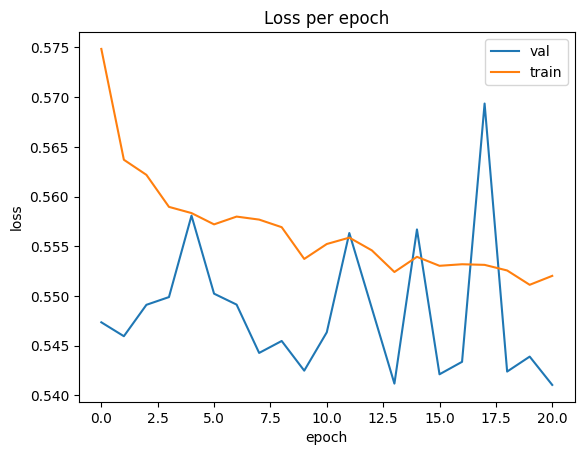

In [ ]:
plot_loss(history)

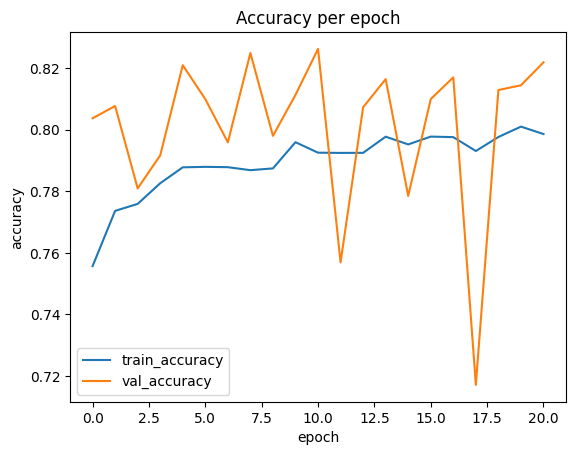

In [ ]:
plot_accuracy(history)

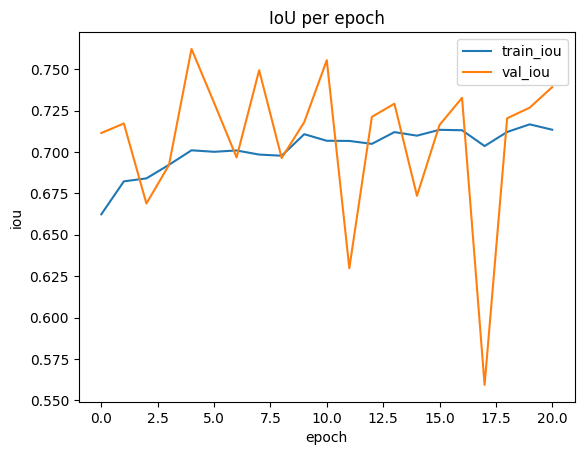

In [ ]:
plot_iou(history)

In [ ]:
torch.save(model.state_dict(), "best_weights_unet_second.pt")

In [ ]:
model.state_dict()

In [ ]:
instances, targets = next(iter(test_dl))
model.eval()
with torch.no_grad():
    preds = (model(instances.to(device))).float().cpu()
preds = preds[2]
print(preds, preds.size())

tensor([[[0.9883, 0.9992, 0.9998,  ..., 0.9999, 0.9989, 0.9769],
         [0.9991, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9985],
         [0.9998, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9998],
         ...,
         [0.5560, 0.6425, 0.6329,  ..., 0.9989, 0.9890, 0.9343],
         [0.5579, 0.6489, 0.6353,  ..., 0.9947, 0.9717, 0.8992],
         [0.4932, 0.5316, 0.5177,  ..., 0.9528, 0.8844, 0.7383]]]) torch.Size([1, 256, 256])


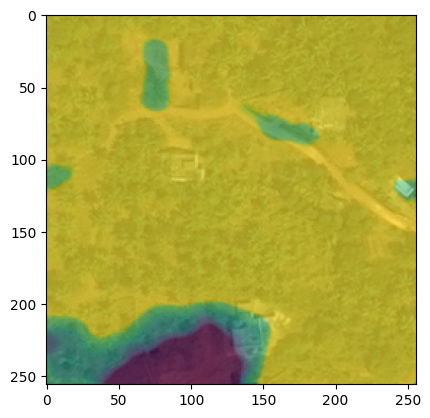

In [ ]:
plt.imshow(0.5 + 0.5 * instances[2].permute(1, 2, 0), cmap="gray");
plt.imshow(preds.permute(1, 2, 0), alpha=0.6);